# Chapter 16. Remedies for Severe Class Imbalance

In [1]:
import os
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('mode.chained_assignment',None)
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"

plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

<Figure size 1000x750 with 0 Axes>

In [2]:
DWDdatafolder = os.path.expanduser("~/Documents/dataset/DWD/data")
assert os.path.isdir(DWDdatafolder)

data_filename='ticdata.RDa'
file_path = os.path.join(DWDdatafolder, data_filename)
datadict = pyreadr.read_r(file_path)

In [3]:
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import linear_model
from sklearn.metrics import make_scorer, cohen_kappa_score, accuracy_score, recall_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, get_scorer_names

In [4]:
def nearZeroVar(X, freqCut):
    columnnames = list(X.columns)
    percentUnique, freqRatio, zeroVar, nzv = [], [], [], []
    for c in columnnames:
        w = X[c]
        valcnt = w.value_counts().values
        percentUnique.append(100* len(valcnt)/valcnt.sum())
        zeroVar.append(True if len(valcnt)==1 else False)
        if len(valcnt)==1: 
            freqRatio.append(0)
        else:
            freqRatio.append(valcnt[0]/valcnt[1])
        nzv.append(freqRatio[-1]==0 or freqRatio[-1]>freqCut)
    df = pd.DataFrame({'col':columnnames, 'freqRatio':freqRatio, 'zeroVar':zeroVar,'nzv':nzv}).set_index('col')
    df.index.name = None
    return df

In [5]:
def modelPerf(model, X, y):
    nl = '\n'
    y_true = y
    y_pred = model.predict(X)
    print(f"Terms: 1 for positive case, and 0 for negative case. \
    {nl}  P - the number of real positive cases in the data \
    {nl}  TP - a test result that correctly indicates the presence of a condition \
    {nl}  FP - a test result which wrongly indicates that a condition is present \
    {nl}  N - the number of real negative cases in the data \
    {nl}  TN - a test result that correctly indicates the absence of a condition \
    {nl}  FN - a test result which wrongly indicates that a condition is absent \
    {nl}  Precision, positive predicitive value(PPV) - TP/(TP+FP) \
    {nl}  Reacll, sensitivity, true positive rate(TPR) - TP/P \
    {nl}  Specificity, selectivity, true negative rate(TNR) - TN/N \
    {nl}  Accuracy - (TP+TN)/(P+N)")
    print(f"The confusion matrix \
    {nl}  TN | FP \
    {nl}  FN | TP")
    print(f"Report of {model.__class__.__name__}:")
    print(classification_report(y_true, y_pred, digits = 7))
    
    f = plt.figure(figsize=(10,4))
    ax1 = f.add_subplot(121)
    cmdisp = ConfusionMatrixDisplay(confusion_matrix(y_true,y_pred), display_labels=model.classes_)
    cmdisp.plot(ax = ax1)
    
    y_score = model.predict_proba(X)[:,1]
    roc_area = roc_auc_score(y_true, y_score)
    ax2 = f.add_subplot(122)
    roc_disp = RocCurveDisplay.from_estimator(model, X, y, ax = ax2)
    print(f"The area under the ROC curve is {roc_area}")

## 1. Data

In [6]:
caravan0 = datadict['ticdata']

convertCols = []
numericCols = []
for x in caravan0.columns:
    if 'float' in caravan0[x].dtype.name:
        numericCols.append(x)
    elif x !='CARAVAN':
        convertCols.append(x)

In [7]:
caravanX = pd.DataFrame()
for x in caravan0.columns:
    if x in convertCols:
        caravanX[x] = caravan0[x].rank(method = 'dense').astype('int')
    elif x in numericCols:
        caravanX[x] = caravan0[x]
caravanY = caravan0['CARAVAN'].map({'insurance':1, 'noinsurance':0})

ct = ColumnTransformer([
    ("OneHotEncode", OneHotEncoder(sparse = False), convertCols),
    ("FloatPass", 'passthrough', numericCols),
], verbose_feature_names_out= False)
caravanXInd = pd.DataFrame(data = ct.fit_transform(caravanX), columns = ct.get_feature_names_out())
firstIndCol = []
for x in convertCols:
    firstIndCol.append(sorted([y for y in caravanXInd.columns if y[:len(x)]==x])[0])
caravanXInd = caravanXInd.drop(columns = firstIndCol)

In [8]:
trainvalidX0, testX0, trainvalidy, testy =train_test_split(caravanXInd, caravanY, random_state=156, test_size=1962)
trainX0, validX0, trainy, validy =train_test_split(trainvalidX0, trainvalidy, random_state=934, test_size=983)

assert trainX0.shape[0]==trainy.shape[0]
assert validX0.shape[0]==validy.shape[0]
assert testX0.shape[0]==testy.shape[0]
trainX0.shape, validX0.shape, testX0.shape

((6877, 503), (983, 503), (1962, 503))

In [9]:
nZV = nearZeroVar(trainX0, 95/5)
isNZVCols = list(nZV[nZV['nzv']].index)
noNZVCols = list(nZV[~nZV['nzv']].index)
len(isNZVCols), len(noNZVCols)

(302, 201)

## 2. The Effect of Class Imbalance

### 2.1 Logistic regression

In [10]:
trainX = trainX0[noNZVCols]
validX = validX0[noNZVCols]
testX = testX0[noNZVCols]

In [11]:
lr = linear_model.LogisticRegression()
logReg_param = [{'solver': ['lbfgs','newton-cg','newton-cholesky','sag'],
                 'penalty':['l2',None]},
                {'solver': ['liblinear'],
                 'penalty':['l1','l2']},
                {'solver': ['saga'],
                 'penalty':['l1','l2',None]}]

In [12]:
lr.fit(trainX, trainy)

LogisticRegression()

In [15]:
scoringDict = {
    'ROC': 'roc_auc',
    'Sens': make_scorer(recall_score),
    'Spec': make_scorer(recall_score,pos_label=0),
    'Accuracy': make_scorer(accuracy_score),
    'Kappa': make_scorer(cohen_kappa_score)
}
scores = cross_validate(lr, trainX, trainy, cv=10, scoring=scoringDict)

for x in scoringDict.keys():
    print(f"{x:>10}: {np.mean(scores['test_'+x]):.4f}")

       ROC: 0.7188
      Sens: 0.0075
      Spec: 0.9988
  Accuracy: 0.9414
     Kappa: 0.0113


Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of LogisticRegression:
              precision    recall  f1-score   support

           0  0.9397959 0.9989154 0.9684543       922
           1  0.6666667 0.0327869 0.0625000        61

    accuracy                      0.9389624       983
   m

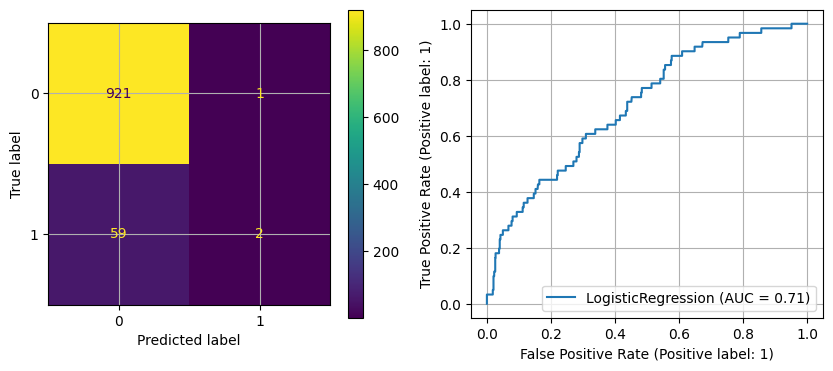

In [17]:
modelPerf(lr, validX, validy)

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of LogisticRegression:
              precision    recall  f1-score   support

           0  0.9366377 0.9989101 0.9667722      1835
           1  0.6000000 0.0236220 0.0454545       127

    accuracy                      0.9357798      1962
   m

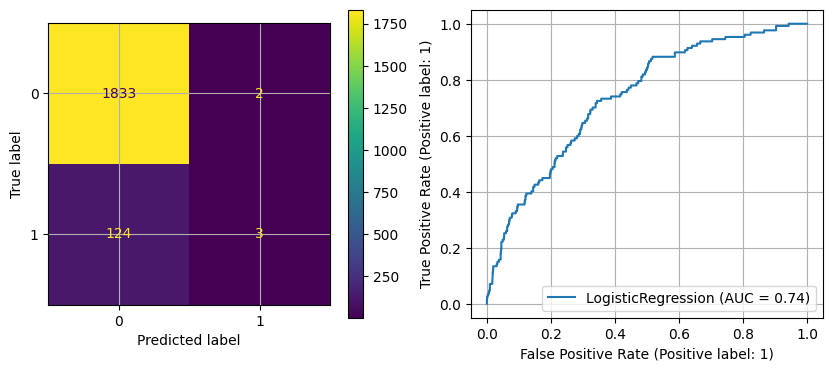

In [18]:
modelPerf(lr, testX, testy)

### 2.2 Random Forest

In [19]:
trainX = trainX0
validX = validX0
testX = testX0

In [22]:
from sklearn.ensemble import RandomForestClassifier
rf  =RandomForestClassifier(n_estimators = 1500, random_state = 76)
rf.fit(trainX, trainy)

RandomForestClassifier(n_estimators=1500, random_state=76)

In [23]:
scores = cross_validate(rf, trainX, trainy, cv=10, scoring=scoringDict)

for x in scoringDict.keys():
    print(f"{x:>10}: {np.mean(scores['test_'+x]):.4f}")

       ROC: 0.6832
      Sens: 0.0479
      Spec: 0.9860
  Accuracy: 0.9317
     Kappa: 0.0508


Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of RandomForestClassifier:
              precision    recall  f1-score   support

           0  0.9393004 0.9902386 0.9640971       922
           1  0.1818182 0.0327869 0.0555556        61

    accuracy                      0.9308240       983


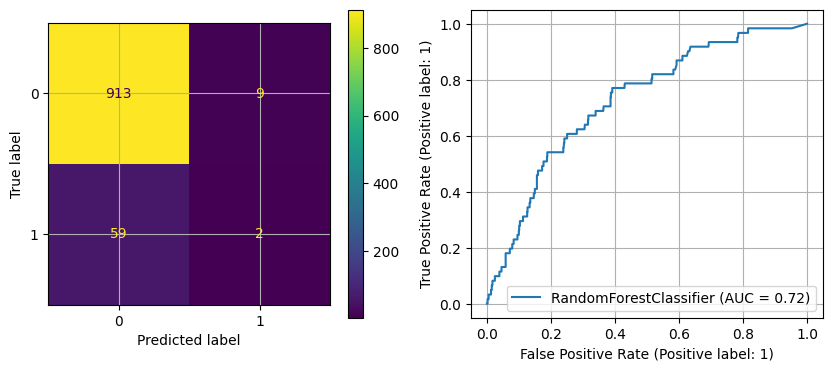

In [24]:
modelPerf(rf,validX, validy)

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of RandomForestClassifier:
              precision    recall  f1-score   support

           0  0.9380165 0.9896458 0.9631398      1835
           1  0.2692308 0.0551181 0.0915033       127

    accuracy                      0.9291539      1962


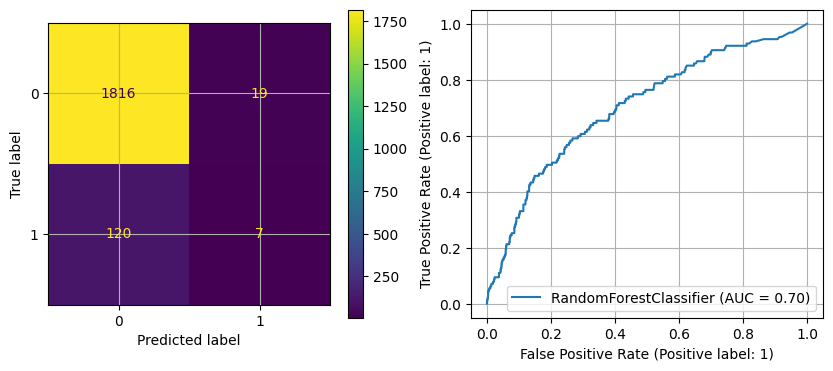

In [25]:
modelPerf(rf,testX,testy)

### 2.3 MARS

In [33]:
trainX = trainX0
validX = validX0
testX = testX0

In [30]:
from pyearth import Earth
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [36]:
fda = Pipeline([('earth', Earth(max_degree=1, penalty=1.5)),
                ('logistic', LogisticRegression())])

fda.fit(trainX, trainy)

Pipeline(steps=[('earth', Earth(max_degree=1, penalty=1.5)),
                ('logistic', LogisticRegression())])

In [37]:
scores = cross_validate(fda, trainX, trainy, cv=10, scoring=scoringDict)

for x in scoringDict.keys():
    print(f"{x:>10}: {np.mean(scores['test_'+x]):.4f}")

       ROC: 0.7354
      Sens: 0.0050
      Spec: 0.9992
  Accuracy: 0.9417
     Kappa: 0.0078


Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of Pipeline:
              precision    recall  f1-score   support

           0  0.9378819 0.9989154 0.9674370       922
           1  0.0000000 0.0000000 0.0000000        61

    accuracy                      0.9369278       983
   macro avg  

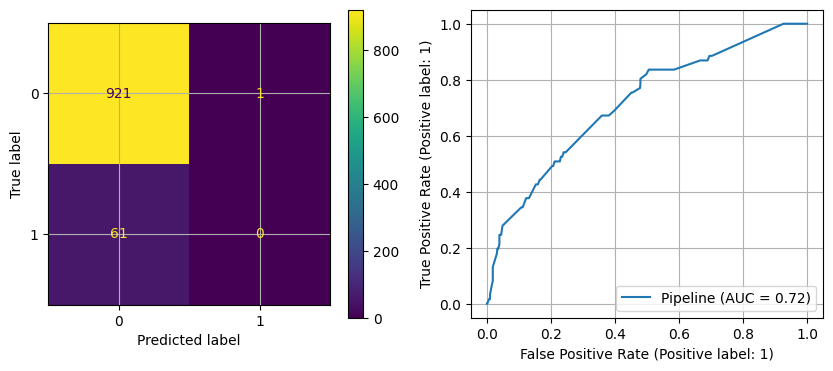

In [38]:
modelPerf(fda,validX, validy)

Terms: 1 for positive case, and 0 for negative case.     
  P - the number of real positive cases in the data     
  TP - a test result that correctly indicates the presence of a condition     
  FP - a test result which wrongly indicates that a condition is present     
  N - the number of real negative cases in the data     
  TN - a test result that correctly indicates the absence of a condition     
  FN - a test result which wrongly indicates that a condition is absent     
  Precision, positive predicitive value(PPV) - TP/(TP+FP)     
  Reacll, sensitivity, true positive rate(TPR) - TP/P     
  Specificity, selectivity, true negative rate(TNR) - TN/N     
  Accuracy - (TP+TN)/(P+N)
The confusion matrix     
  TN | FP     
  FN | TP
Report of Pipeline:
              precision    recall  f1-score   support

           0  0.9352371 0.9994550 0.9662803      1835
           1  0.0000000 0.0000000 0.0000000       127

    accuracy                      0.9347604      1962
   macro avg  

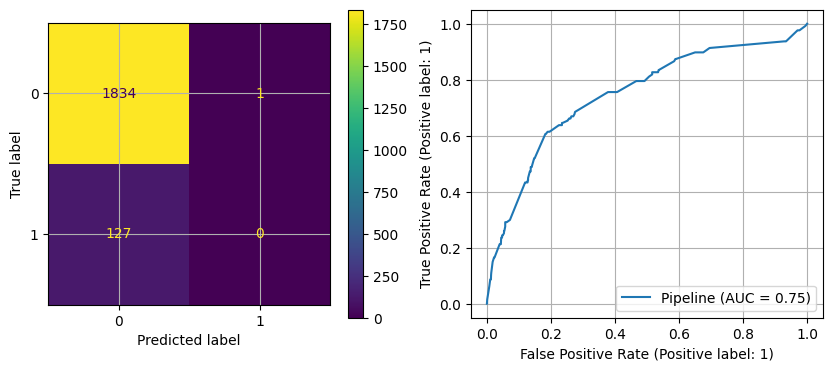

In [39]:
modelPerf(fda,testX,testy)

### 2.4 Summary plots

In [55]:
validX = validX0

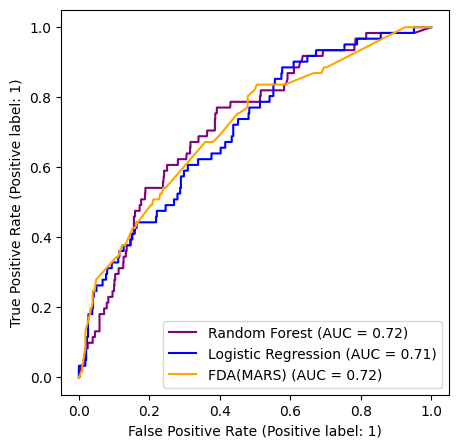

In [66]:
fig, ax1  = plt.subplots(figsize=(5,5))
ax1.grid(False)
roc_disp1 = RocCurveDisplay.from_estimator(rf, validX, validy,name = "Random Forest",c = 'purple',ax =ax1)
roc_disp2 = RocCurveDisplay.from_estimator(lr, validX[noNZVCols], validy, name = "Logistic Regression",c ="blue", ax =ax1)
roc_disp3 = RocCurveDisplay.from_estimator(fda, validX, validy, name = "FDA(MARS)", c = "orange",ax =ax1)

In [96]:
def plotCumulativeGain(XList, yList, modelList, nameList = None):
    if not nameList:
        nameList = [model.__class__.__name__ for model in modelList]
    cg = []
    for i in range(len(modelList)):
        model =modelList[i]
        X_test = XList[i]
        y_test = yList[i]
        y_score = model.predict_proba(X_test)[:,1]
        n_samples, n_pos = len(y_test), sum(y_test)
        dfy = pd.DataFrame({'score':y_score,'true': y_test}).sort_values('score',ascending = False)
        dfy['no'] = 1
        dfy['cum_pos'] = dfy['true'].cumsum()/n_pos
        dfy['cum_sample'] = dfy['no'].cumsum()/n_samples
        cg.append(dfy[['cum_pos','cum_sample']])
        
    _, ax=plt.subplots(figsize=(5,5))
    for i in range(len(cg)):
        sns.lineplot(cg[i]*100, x= 'cum_sample', y = 'cum_pos',label=nameList[i])
    ax.set(xlabel = '% Samples Tested', ylabel = '% Samples Found')

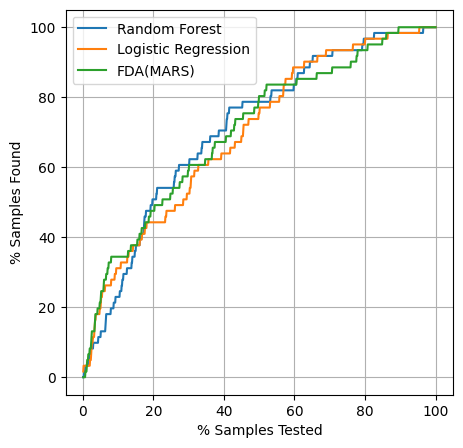

In [98]:
plotCumulativeGain([validX,validX[noNZVCols],validX],[validy.astype('int')]*3, [rf,lr,fda],['Random Forest','Logistic Regression', 'FDA(MARS)'])